In [3]:
%matplotlib inline

In [4]:
import pandas as pd
from Bio import SeqIO
from matplotlib import pyplot as plt
import numpy as np

In [5]:
df = pd.read_excel('/Users/adamhockenberry/Downloads/TSS_annotation_8_10_2016.xlsx', index_col='Position')
genome = list(SeqIO.parse('../Data/Genomes/fa1090.gb', 'genbank'))[0]

In [6]:
df

,Strand,Obv in Control,Obv in H2O2,Decrease under TEX,Magnitude in No Tex,Magnitude in +TEX,Fold Increase,Notes,Unnamed: 9,Unnamed: 10,Range,Unnamed: 12,Unnamed: 13,Looks exemplarary?,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
Position,,,,,,,,,,,,,,,,,,
68,+,Y,Y,NaN,600,10000,16.666667,NaN,Notes,NaN,NC_002946:0-200,NaN,NaN,dnaA,upstream looks really good is next to an operon,NaN,NaN,NaN
3659,+,Y,Y,NaN,35,200,5.714286,NaN,NaN,NaN,NC_002946:3600-3800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11773,+,Y,Y,NaN,200,800,4.000000,NaN,samples.,NaN,NC_002946:11700-11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22551,+,Y,Y,NaN,100,2000,20.000000,NaN,NaN,NaN,NC_002946:22450-22650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27860,+,Y,Y,NaN,5,100,20.000000,NaN,NaN,NaN,NC_002946:27800-28000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30935,+,Y,Y,NaN,150,1,0.006667,NaN,NaN,NaN,NC_002946:30800-31000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31767,+,Y,Y,NaN,150,800,5.333333,NaN,NaN,NaN,NC_002946:31700-31900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32228,+,Y,Y,NaN,4000,9000,2.250000,NaN,NaN,NaN,NC_002946:32200-32400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36090,+,Y,Y,NaN,200,1000,5.000000,NaN,NaN,NaN,NC_002946:36000-36200,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
genes_dicty_plus = {}
genes_dicty_minus = {}
for feature in genome.features:
    if feature.type == 'gene':
        if feature.location.strand == 1:
            genes_dicty_plus[feature.qualifiers['locus_tag'][0]] = (int(feature.location.start), int(feature.location.end))
        elif feature.location.strand == -1:
            genes_dicty_minus[feature.qualifiers['locus_tag'][0]] = (int(feature.location.start), int(feature.location.end))

# Definition:
1. First check for primary
2. Next check for secondary (500 to 250)
3. Inside of a gene?
4. Anti-sense?
5. Outside of all categories

In [6]:
secondary_buffer = 500
primary_buffer = 250

df['Primary'] = ''
df['Secondary'] = ''
df['Internal'] = ''
df['Anti-sense'] = ''
df['Orphan'] = ''

#####################################
#######First get primaries
genes_with_a_primary = []
for tss in df.index:
    if df.loc[tss]['Strand'] == '+':
        for gene in genes_dicty_plus.keys():
            if int(tss) > genes_dicty_plus[gene][0]-primary_buffer and tss < genes_dicty_plus[gene][0]:
                df.set_value(tss, 'Primary', 'Y')
                genes_with_a_primary.append(gene)
                break
    elif df.loc[tss]['Strand'] == '-':
        for gene in genes_dicty_minus.keys():
            if int(tss) < genes_dicty_minus[gene][1]+primary_buffer and tss > genes_dicty_minus[gene][1]:
                df.set_value(tss, 'Primary', 'Y')
                genes_with_a_primary.append(gene)
                break
#####################################
#######Now check for internals
for tss in df.index:
    if df.loc[tss]['Strand'] == '+':
            for gene in genes_dicty_plus.keys():
                if int(tss) > genes_dicty_plus[gene][0] and tss < genes_dicty_plus[gene][1]:
                    df.set_value(tss, 'Internal', 'Y')
                    break
    elif df.loc[tss]['Strand'] == '-':
        for gene in genes_dicty_minus.keys():
            if int(tss) > genes_dicty_minus[gene][0] and tss < genes_dicty_minus[gene][1]:
                df.set_value(tss, 'Internal', 'Y')
                break
                
#####################################
#######And anti-sense
for tss in df.index:
    if df.loc[tss]['Strand'] == '-':
            for gene in genes_dicty_plus.keys():
                if int(tss) > genes_dicty_plus[gene][0] and tss < genes_dicty_plus[gene][1]:
                    df.set_value(tss, 'Anti-sense', 'Y')
                    break
    elif df.loc[tss]['Strand'] == '+':
        for gene in genes_dicty_minus.keys():
            if int(tss) > genes_dicty_minus[gene][0] and tss < genes_dicty_minus[gene][1]:
                df.set_value(tss, 'Anti-sense', 'Y')
                break
                
#####################################
#######Leftovers are lonely orphans
for tss in df.index:
    if df.loc[tss]['Primary'] == '' and df.loc[tss]['Internal'] == '' and df.loc[tss]['Anti-sense'] == '':
        df.set_value(tss, 'Orphan', 'Y')

#####################################
#######Print out a summary
for category in ['Primary', 'Internal', 'Anti-sense', 'Orphan']:
    print(category, len(df[df[category] != '']))

Primary 306
Internal 402
Anti-sense 270
Orphan 196


In [33]:
secondary_buffer = 500
primary_buffer = 250
anti_sense_buffer = 100

df['Primary'] = ''
df['Secondary'] = ''
df['Internal'] = ''
df['Anti-sense'] = ''
df['Orphan'] = ''

#####################################
#######First get primaries
genes_with_a_primary = []
utr_lengths_plus = []
utr_lengths_minus = []
for tss in df.index:
    if df.loc[tss]['Strand'] == '+':
        for gene in genes_dicty_plus.keys():
            if int(tss) > genes_dicty_plus[gene][0]-primary_buffer and tss < genes_dicty_plus[gene][0]:
                df.set_value(tss, 'Primary', 'Y')
                genes_with_a_primary.append(gene)
                utr_lengths_plus.append(genes_dicty_plus[gene][0] - tss)
                break
    elif df.loc[tss]['Strand'] == '-':
        for gene in genes_dicty_minus.keys():
            if int(tss) < genes_dicty_minus[gene][1]+primary_buffer and tss > genes_dicty_minus[gene][1]:
                df.set_value(tss, 'Primary', 'Y')
                genes_with_a_primary.append(gene)
                utr_lengths_minus.append(tss - genes_dicty_minus[gene][1])
                break
#####################################
#######Now check for internals
for tss in df.index:
    if df.loc[tss]['Strand'] == '+':
            for gene in genes_dicty_plus.keys():
                if int(tss) > genes_dicty_plus[gene][0] and tss < genes_dicty_plus[gene][1]:
                    df.set_value(tss, 'Internal', 'Y')
                    break
    elif df.loc[tss]['Strand'] == '-':
        for gene in genes_dicty_minus.keys():
            if int(tss) > genes_dicty_minus[gene][0] and tss < genes_dicty_minus[gene][1]:
                df.set_value(tss, 'Internal', 'Y')
                break
                
#####################################
#######And anti-sense
for tss in df.index:
    if df.loc[tss]['Strand'] == '-':
            for gene in genes_dicty_plus.keys():
                if int(tss) > genes_dicty_plus[gene][0]-anti_sense_buffer and tss < genes_dicty_plus[gene][1]+anti_sense_buffer:
                    df.set_value(tss, 'Anti-sense', 'Y')
                    print('minus!')
                    break
    elif df.loc[tss]['Strand'] == '+':
        for gene in genes_dicty_minus.keys():
            if int(tss) > genes_dicty_minus[gene][0]-anti_sense_buffer and tss < genes_dicty_minus[gene][1]+anti_sense_buffer:
                df.set_value(tss, 'Anti-sense', 'Y')
                print('plus!')
                break
                
#####################################
#######Secondaries don't make sense, but here they are
for tss in df.index:
    if df.loc[tss]['Strand'] == '+':
        for gene in genes_dicty_plus.keys():
            if int(tss) > genes_dicty_plus[gene][0]-secondary_buffer and tss < genes_dicty_plus[gene][0]-primary_buffer:
                if gene in genes_with_a_primary:
                    df.set_value(tss, 'Secondary', 'Y')
                    genes_with_a_primary.append(gene)
                    break
    elif df.loc[tss]['Strand'] == '-':
        for gene in genes_dicty_minus.keys():
            if int(tss) < genes_dicty_minus[gene][1]+secondary_buffer and tss > genes_dicty_minus[gene][1]+primary_buffer:
                if gene in genes_with_a_primary:
                    df.set_value(tss, 'Secondary', 'Y')
                    genes_with_a_primary.append(gene)
                    break
                
#####################################
#######Leftovers are lonely orphans
for tss in df.index:
    if df.loc[tss]['Primary'] == '' and df.loc[tss]['Internal'] == '' and df.loc[tss]['Anti-sense'] == '':
        df.set_value(tss, 'Orphan', 'Y')

#####################################
#######Print out a summary
for category in ['Primary', 'Internal', 'Anti-sense', 'Orphan', 'Secondary']:
    print(category, len(df[df[category] != '']))
    
with open('../Results/2016_08_12/summary.txt', 'w') as outfile:
    outfile.write('Total TSS:\t {}\n'.format(len(df.index)))
    for category in ['Primary', 'Internal', 'Anti-sense', 'Orphan', 'Secondary']:
        outfile.write('{}:\t {}\n'.format(category, len(df[df[category] != ''])))

df.to_excel('../Results/2016_10_14/TSS_annotations_with_assignment.xlsx')

plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus!
plus

In [18]:
# df[df['Obv in Control'] != df['Obv in H2O2']].to_excel('../Results/2016_10_06/TSS_annotations_with_assignment_different.xlsx')
# df.to_excel('../Results/2016_10_06/TSS_annotations_with_assignment.xlsx')

In [34]:
category = 'Orphan'
print(len(df[df[category] != ''][df['Strand'] == '+']))
print(len(df[df[category] != ''][df['Strand'] == '-']))

78
65


/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


306


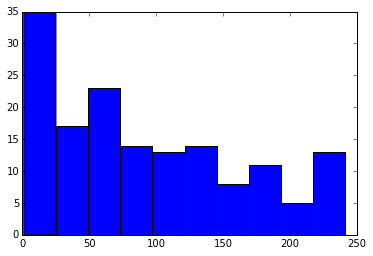

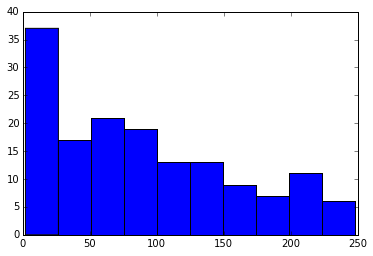

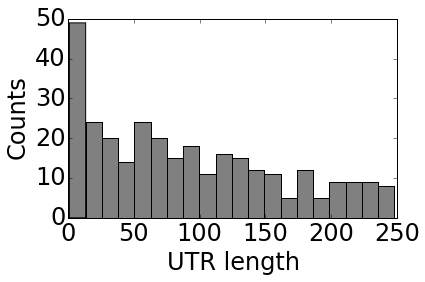

In [66]:
plt.figure()
plt.hist(utr_lengths_plus)
plt.figure()
plt.hist(utr_lengths_minus)
plt.figure()
plt.hist(utr_lengths_plus + utr_lengths_minus, 20, facecolor='0.5')
plt.tick_params(labelsize=24)
plt.xlabel('UTR length', fontsize=24)
plt.ylabel('Counts', fontsize=24)
plt.tight_layout()
plt.savefig('../Results/2016_08_12/UTR_length_hist.pdf')
print(len(utr_lengths_minus)+len(utr_lengths_minus))

# Extracting TSS regions for motif analysis
The first TSS at position 68 is currently ignored because concatenating the end of the genome in order to get the fully 100 nts upstream is annoying me and its one tss after all

In [20]:
with open('../Results/2016_10_06/all_tss_surrounding.fasta', 'w') as outfile:
    for tss in df.index:
        outfile.write('>{}|{}\n'.format(tss, df.loc[tss]['Strand']))
        if df.loc[tss]['Strand'] == '+':
            outfile.write('{}\n'.format(str(genome.seq[tss-50:tss+50])))
        elif df.loc[tss]['Strand'] == '-':
            outfile.write('{}\n'.format(str(genome.seq[tss-50:tss+50].reverse_complement())))

In [63]:
# category_of_interest = 'Primary'
# category_of_interest = 'Orphan'
# category_of_interest = 'Secondary'
# category_of_interest = 'Internal'
# category_of_interest = 'Anti-sense'

upstream = 100
downstream = 0
with open('../Results/2016_10_14/{}_tss_surrounding_minus{}_plus{}.fasta'.format(category_of_interest, upstream, downstream), 'w') as outfile:
    for tss in df.index:
        if df.loc[tss][category_of_interest] != '':
            if tss - upstream > 0 and tss - downstream > 0:
                outfile.write('>{}|{}\n'.format(tss, df.loc[tss]['Strand']))
                if df.loc[tss]['Strand'] == '+':
                    outfile.write('{}\n'.format(str(genome.seq[tss-upstream:tss+downstream])))
                elif df.loc[tss]['Strand'] == '-':
                    outfile.write('{}\n'.format(str(genome.seq[tss-downstream:tss+upstream].reverse_complement())))

In [8]:
for tss in df.index:
    if isinstance(df.loc[tss]['Strand'], str) == False:
        print(tss)

In [14]:
counter = 0
upstream = 30
downstream = 30
with open('../Results/2016_11_02/strong_tss_surrounding_minus{}_plus{}.fasta'.format(upstream, downstream), 'w') as outfile:
    for tss in df.index:
        if df.loc[tss]['Fold Increase'] > 2 and min([df.loc[tss]['Magnitude in No Tex'], df.loc[tss]['Magnitude in +TEX']]) > 5:
            if tss - upstream > 0 and tss - downstream > 0:
                outfile.write('>{}|{}\n'.format(tss, df.loc[tss]['Strand']))
                if df.loc[tss]['Strand'] == '+':
                    outfile.write('{}\n'.format(str(genome.seq[tss-upstream:tss+downstream])))
                elif df.loc[tss]['Strand'] == '-':
                    outfile.write('{}\n'.format(str(genome.seq[tss-downstream:tss+upstream].reverse_complement())))
                counter += 1
print(counter)

990


In [71]:
counter = 0
with open('../Results/2016_10_14/short_upstream_all.fasta', 'w') as outfile:
    for tss in df.index:
        if min([df.loc[tss]['Magnitude in No Tex'], df.loc[tss]['Magnitude in +TEX']]) > 10 and df.loc[tss]['Fold Increase'] > 2:
            outfile.write('>{}|{}\n'.format(tss, df.loc[tss]['Strand']))
            if df.loc[tss]['Strand'] == '+':
                outfile.write('{}\n'.format(str(genome.seq[tss-40:tss])))
            elif df.loc[tss]['Strand'] == '-':
                outfile.write('{}\n'.format(str(genome.seq[tss:tss+40].reverse_complement())))
            counter += 1
print(counter)

916
